In [0]:
from google.colab import drive


In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from sklearn.model_selection import train_test_split
import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import preprocess_input
from keras.metrics import top_k_categorical_accuracy
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from keras.regularizers import l2, l1

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!ls

gdrive	sample_data


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from keras.applications.mobilenet_v2 import MobileNetV2

In [0]:
def cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(2, 2), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Conv2D(8, kernel_size=(2, 2), strides=(1, 1),
                 activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [0]:
def main(X, y):
  
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
    model = cnn_model((64, 64,3), 337)
    model.fit(X_train, y_train, verbose=1,shuffle=True, validation_data=(X_valid, y_valid), epochs=64)

In [0]:
def main_lr(X, y):
  
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train,X_valid = X_train.reshape(X_train.shape[0], 32*32*3), X_valid.reshape(X_valid.shape[0], 32*32*3)
    model = LogisticRegression(random_state=0, solver='sag', multi_class='multinomial').fit(X_train, y_train)
    model.score(X_valid, y_valid)

In [0]:
def main_svm(X,y):
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
  model = svm.SVC(gamma='scale', decision_function_shape='ovo')
  model.fit(X_train, y_train)
  model.score(X_valid, y_valid)

In [0]:
def main_mobilenet(Xtrain, ytrain, Xvalid, yvalid, train_batch_size = 1000, valid_batch_size = 1000):
    train_datagen = ImageDataGenerator(
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest',
          preprocessing_function = preprocess_input)
    train_generator = train_datagen.flow(x = Xtrain, y = ytrain,
                batch_size = train_batch_size,\
                shuffle = False
                )
    valid_datagen = ImageDataGenerator(
                preprocessing_function = preprocess_input)
    valid_generator = valid_datagen.flow(x = Xvalid, y = yvalid,
                batch_size = valid_batch_size,\
                shuffle = False
                )
    mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    for layer in mobilenet.layers[:]:
        layer.trainable = True
    model = Sequential()
    model.add(mobilenet)
    model.add(Flatten())
    model.add(Dense(640, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation="relu"))
    model.add(Dense(15, kernel_regularizer=l2(0.01),
                activity_regularizer=l1(0.01), activation="softmax"))
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=[top_k_categorical_accuracy])
    history = model.fit_generator(
      train_generator,
      steps_per_epoch=np.ceil(Xtrain.shape[0]/train_batch_size) ,
      epochs=30,
      validation_data=valid_generator,
      validation_steps=np.ceil(Xvalid.shape[0]/valid_batch_size),
      verbose=1)
    return model
    
  
  

In [0]:
def main_encode_mobilenet(Xtrain, ytrain):
    train_datagen = ImageDataGenerator(rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest',
          preprocessing_function = preprocess_input)
    train_generator = train_datagen.flow(x = Xtrain,
                batch_size = 128,\
                shuffle = False
                )
    mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    encoded = mobilenet.predict_generator(
      train_generator,
      steps=np.ceil(Xtrain.shape[0]/128) ,
      verbose=1)
    return encoded
    
  

In [0]:
from sklearn.preprocessing import LabelBinarizer

def one_hot_encoding(y):
    '''
    Convert labels y to one hot encoding.
    '''
    label_binarizer = LabelBinarizer()
    y_one_hot = label_binarizer.fit_transform(y)
    return y_one_hot

In [0]:
path_train_data = "/content/gdrive/My Drive/yelp_project/groupped_train_food101.npz"
train_data = np.load(path_train_data)
X, y = train_data["arr_0"], train_data["arr_1"]

path_test_data = "/content/gdrive/My Drive/yelp_project/groupped_test_food101.npz"
test_data = np.load(path_test_data)
X_test, y_test = test_data["arr_0"], test_data["arr_1"]

print(X.shape, y.shape)





(75747, 64, 64, 3) (75747,)


In [0]:
y, y_test = one_hot_encoding(y), one_hot_encoding(y_test)

In [0]:
X.shape

(7499, 64, 64, 3)

In [0]:
model = main_mobilenet(X, y, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/30
76/76 [==============================] - 74s 969ms/step - loss: 13.0494 - top_k_categorical_accuracy: 0.4719 - val_loss: 12.7566 - val_top_k_categorical_accuracy: 0.5447
Epoch 2/30
76/76 [==============================] - 65s 851ms/step - loss: 12.8436 - top_k_categorical_accuracy: 0.5082 - val_loss: 12.6545 - val_top_k_categorical_accuracy: 0.5815
Epoch 3/30
76/76 [==============================] - 66s 868ms/step - loss: 12.7864 - top_k_categorical_accuracy: 0.5371 - val_loss: 12.7401 - val_top_k_categorical_accuracy: 0.5833
Epoch 4/30
76/76 [==============================] - 66s 874ms/step - loss: 12.7833 - top_k_categorical_accuracy: 0.5423 - val_loss: 12.6739 - val_top_k_categorical_accuracy: 0.6098
Epoch 5/30
76/76 [==============================] - 66s 870ms/step - loss: 12.7401 - top_k_categorical_accuracy: 0.5434 - val_loss: 12.7107 - val_top_k_categorical_accuracy: 0.6132
Epoch 6/30
76/76 [==============================] - 66s 875ms/step - loss: 12.7170 - top_k_cate

In [0]:
encoded.shape

(100997, 2, 2, 1280)

In [0]:
model.save("model.h5")

In [0]:
from keras.models import load_model
from matplotlib import pyplot

model_1 = load_model("/content/gdrive/My Drive/yelp_project/model.h5")

In [0]:
image = X[1, :, :, :]
model_1.predict(np.expand_dims(image, axis=0))

array([[0.00466723, 0.02816449, 0.4983326 , 0.01367121, 0.07252035,
        0.03238272, 0.0070372 , 0.01013172, 0.03773452, 0.00616696,
        0.02515748, 0.03266957, 0.10978059, 0.05639118, 0.06519213]],
      dtype=float32)

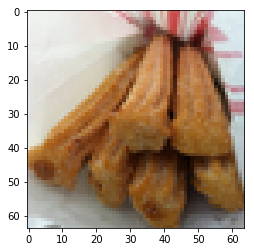

In [0]:
pyplot.imshow(image)
pyplot.show()

In [0]:
np.savez_compressed("encoded.npz", encoded)

In [0]:
path_data = "/content/gdrive/My Drive/yelp_project/food101.npz"
data = np.load(path_data)
X, y = data["arr_0"], data["arr_1"]

encoded = np.load("/content/gdrive/My Drive/yelp_project/encoded.npz")["arr_0"]

encoded = encoded.reshape(encoded.shape[0], 2*2*1280)
X_train, X_valid, y_train, y_valid = train_test_split(encoded, y, test_size=0.1, random_state=42)
#pca = PCA(n_components=100)
#pca.fit(X_train)
#X_train = pca.transform(X_train)
#X_valid = pca.transform(X_valid)
#print(X_train.shape)
#print(X_valid.shape)
X_train,X_valid = preprocessing.scale(X_train), preprocessing.scale(X_valid)
#model = LogisticRegression(random_state=0, solver='sag', multi_class='multinomial').fit(X_train, y_train)
#model.score(X_valid, y_valid)
#model = svm.SVC(gamma='scale', decision_function_shape='ovr')
#model.fit(X_train, y_train)
#model.score(X_valid, y_valid)
model = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were enc

In [0]:
model.score(X_valid, y_valid)

0.05297029702970297

In [0]:
def main_nasnet(Xtrain, ytrain):
    train_datagen = ImageDataGenerator(
                shear_range = 0.2, \
                zoom_range = 0.2, \
                preprocessing_function = preprocess_input,\
                horizontal_flip = True)
    train_generator = train_datagen.flow(x = Xtrain,
                batch_size = 128,\
                shuffle = False
                )
    nasnet = NASNetMobile(input_shape = (64,64,3), include_top=False, weights='imagenet')
    encoded = nasnet.predict_generator(
      train_generator,
      steps=np.ceil(Xtrain.shape[0]/128) ,
      verbose=1)
    return encoded
    
  